In [ ]:
#Multi-Classification on Stack Overflow questions

https://www.tensorflow.org/tutorials/keras/text_classification#exercise_multi-class_classification_on_stack_overflow_questions

In [168]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import re
import numpy as np
# import shutil
import string
import tarfile


## Import Data


In [12]:
so_data_url = './data/stack_overflow_16k.tar.gz'
test_dir = './data/test'

if os.path.exists(test_dir) and os.path.isdir(test_dir):
  print('tar extracted')
elif os.path.exists(so_data_url):
  with tarfile.open(so_data_url, 'r:gz') as tar:
    tar.extractall(path='./data/')

In [17]:
url = "./data/test/"
ds_dir = os.path.join("./data", "stack_overflow")
print(ds_dir)

sample_file = os.path.join(ds_dir, "test/python/10.txt")
with open(sample_file, "r") as f:
  print(f.read())


./data/stack_overflow
"idiomatic blank iterating and adding to a dict i'm running through a string, creating all substrings of size 10, and adding them to a dict. this is my code,..sequence_map = {}.for i in range(len(s)):.    sub = s[i:i+10].    if sub in sequence_map:.       sequence_map[sub] += 1.    else:.       sequence_map[sub] = 1...is there a way to do this more blankically?..also how do i do the reverse blankically, as in interating through the dict and composing a list where value is equal to something?..[k for k, v in sequence_map.items()]"



In [212]:
def simple_standardize(input_data):
    lowercased = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercased, '<br />', ' ')
    punctuation = tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

    return punctuation

# see .get_vocabulary() below
max_tokens = 10000
vectorize_layer = tf.keras.layers.TextVectorization(
  standardize=simple_standardize,
  # standardize='lower_and_strip_punctuation',
  max_tokens=max_tokens,
  output_mode="int", #unique int index for each token 
  output_sequence_length=150
)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [213]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
  os.path.join(ds_dir, "train"),
  batch_size=batch_size,
  validation_split=0.2,
  subset='training',
  seed=seed
)
raw_validation_ds = tf.keras.utils.text_dataset_from_directory(
  os.path.join(ds_dir, "train"),
  batch_size=batch_size,
  validation_split=0.2,
  subset='validation',
  seed=seed
)
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
  os.path.join(ds_dir, "test"),
  batch_size=batch_size
)

train_text = raw_train_ds.map(lambda x, _y: x)
#adapt: Computes a vocabulary of string terms from tokens in a dataset.
# else you'll get an error: 
# FailedPreconditionError: Graph execution error:
#     Table not initialized.
vectorize_layer.adapt(train_text)
# max_tokens train_set: 99853
print("max_tokens train_set:", len(vectorize_layer.get_vocabulary()))
classes = raw_train_ds.class_names
print("classes:", classes)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.
max_tokens train_set: 10000
classes: ['csharp', 'java', 'javascript', 'python']


In [118]:
print(type(raw_train_ds))
train_ds = raw_train_ds.map(vectorize_text)
validation_ds = raw_validation_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# AUTOTUNE - uses system to determine the buffer size
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [221]:
embedding_dim = 16
model = tf.keras.Sequential(
  name='sequential_embedding_001',
  layers=[
  tf.keras.layers.Embedding(max_tokens + 1, embedding_dim),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling1D(),
  # GlobalAveragePooling1D - returns fixed length output vector
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4)
])
model.summary(show_trainable=True)

model.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  # 
  optimizer='adam',
  # Adaptive Moment Estimation - stochastic optimization
  # fn that updates each param individually. provides exp
  # decaying average of past gradients (momentum)
  # and squared gradients (RMSProp)
  # metrics=tf.metrics.SparseCategoricalAccuracy()
  metrics=['accuracy']
)

# callbacks = [
#   tf.keras.callbacks.EarlyStopping(
#     monitor="loss",
#     patience=2,
#     verbose=1,
#     min_delta=0.01,
#     mode="min",
#   )
# ]

Model: "sequential_embedding_001"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 embedding_30 (Embedding)    (None, None, 16)          160016    Y          
                                                                            
 dropout_59 (Dropout)        (None, None, 16)          0         Y          
                                                                            
 global_average_pooling1d_3  (None, 16)                0         Y          
 0 (GlobalAveragePooling1D)                                                 
                                                                            
 dropout_60 (Dropout)        (None, 16)                0         Y          
                                                                            
 dense_28 (Dense)            (None, 4)                 68        Y          
                                          

In [230]:
epochs = 16
fit_history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs,
  # callbacks=callbacks
  verbose='auto'
)

loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", round(accuracy*100), "%")

Epoch 1/16
200/200 [==============================] - 1s 6ms/step - loss: 0.3105 - accuracy: 0.9197 - val_loss: 0.5333 - val_accuracy: 0.8000
Epoch 2/16
200/200 [==============================] - 1s 4ms/step - loss: 0.2960 - accuracy: 0.9262 - val_loss: 0.5309 - val_accuracy: 0.7975
Epoch 3/16
200/200 [==============================] - 1s 3ms/step - loss: 0.2853 - accuracy: 0.9273 - val_loss: 0.5288 - val_accuracy: 0.7987
Epoch 4/16
200/200 [==============================] - 1s 4ms/step - loss: 0.2723 - accuracy: 0.9381 - val_loss: 0.5271 - val_accuracy: 0.8000
Epoch 5/16
200/200 [==============================] - 1s 4ms/step - loss: 0.2608 - accuracy: 0.9377 - val_loss: 0.5257 - val_accuracy: 0.7994
Epoch 6/16
200/200 [==============================] - 1s 4ms/step - loss: 0.2504 - accuracy: 0.9384 - val_loss: 0.5250 - val_accuracy: 0.7994
Epoch 7/16
200/200 [==============================] - 1s 3ms/step - loss: 0.2406 - accuracy: 0.9456 - val_loss: 0.5248 - val_accuracy: 0.8006
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


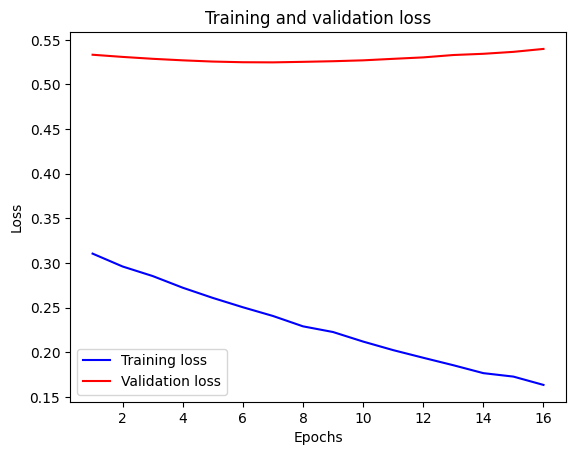

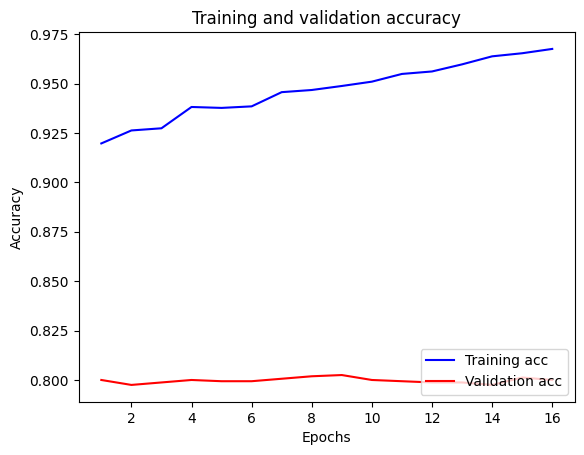

In [231]:
h_dict = fit_history.history
print(h_dict.keys())

acc = h_dict['accuracy']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, h_dict['loss'], 'b', label='Training loss')
# b is for "solid blue line", r is for "solid red line"
plt.plot(epochs, h_dict['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, h_dict['val_accuracy'], 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [232]:
model.save('./models/model_001.h5')

/usr/local/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [233]:
l_model = tf.keras.models.load_model('./models/model_001.h5')
worker_model = tf.keras.Sequential([
  vectorize_layer,
  l_model,
])

In [234]:
data = [
  'What is the way of declaring an array in JavaScript?',
  'How to update python to the latest version of django?',
  'how to make a class in java',
  "how to specify the connection string if the excel file name contains white space?using blank string connstring = ""provider=microsoft.ace.oledb.12.0;data source=d:\data\[proj_resource details 20110118.xlsx];extended properties=excel 12.0"";...i mentioned [ ] still it is throwing exception.how can i solve this problem..plz mention the correct path"
]
# data = [vectorize_text(t, '') for t in data]
print(data)
p = worker_model.predict(data)
print(classes)
print(p)
[classes[x] for x in np.argmax(p, axis=1)]


['What is the way of declaring an array in JavaScript?', 'How to update python to the latest version of django?', 'how to make a class in java', 'how to specify the connection string if the excel file name contains white space?using blank string connstring = provider=microsoft.ace.oledb.12.0;data source=d:\\data\\[proj_resource details 20110118.xlsx];extended properties=excel 12.0;...i mentioned [ ] still it is throwing exception.how can i solve this problem..plz mention the correct path']
1/1 [==============================] - 0s 103ms/step
['csharp', 'java', 'javascript', 'python']
[[ 0.48528638  0.02784687  0.34149098 -0.947502  ]
 [ 0.17861797  0.5123785  -0.29453865 -0.5567937 ]
 [ 0.36816552 -0.08899807  0.37222457 -0.65177536]
 [ 0.5219288   0.59298176 -0.81223726 -0.5659554 ]]


['csharp', 'java', 'javascript', 'java']